In [2]:
import pandas as pd
import spacy
import ast
import numpy as np
 
location = pd.read_csv("../MT data/location.csv")
year = pd.read_csv("../MT data/year.csv")
level_1 = pd.read_csv('../MT data/level_1.csv')
#exclude papers on CCS that are also not deal with any other relevant technology
year_without_CCS = year.loc[~((year['CCS'] == 1) & (year['Biochar'] == 0) & (year['BECCS'] == 0) & (year['Blue Carbon'] == 0) 
                              & (year["Ocean alkalinity enhancement"] == 0) & (year['Forest Management'] == 0)
                              & (year['Soil Carbon Sequestration'] == 0)
                              & (year['Agroforestry'] == 0) & (year['Enhanced Weathering (land based)'] == 0)
                              & (year['Ocean fertilization & Artificial upwelling'] == 0)
                              & (year["DAC(CS)"] == 0) & (year['General Literature on CDR/NET'] == 0)
                              & (year["AR"] == 0)  & (year["restoration of landscapes/peats"] == 0)),:]

location = pd.merge(location, year_without_CCS[['id']], on='id', how='inner')
location = pd.merge(location, level_1[['id']], on='id', how='inner')

Use spacy to retrieve the locations

In [227]:
nlp = spacy.load("en_core_web_sm")

columns = ["title", "abstract"]

entities = []

for index, row in location.iterrows():
    row_entities = []
    for column in columns:
        doc = nlp(row[column])
        for ent in doc.ents:
            if ent.label_ == "GPE": 
                row_entities.append(ent.text)
    entities.append(row_entities)

location["Entities"] = entities
location.dropna(subset=["Entities"], inplace=True)
location['Entities'] = location['Entities'].apply(lambda x: list(set(x)))

location[['id', 'Entities']].to_csv('../MT data/locations_NER.csv', index=False)

Change special names in the dataset (UK, US) and exclude Kyoto and Paris

In [228]:
df = pd.read_csv("../MT data/locations_NER.csv", converters={"Entities":ast.literal_eval})

df_ex = df[['id','Entities']].explode("Entities")
df_ex['Entities'] = df_ex['Entities'].replace(['Kyoto', 'Paris'], np.nan)
df_ex.dropna(subset=["Entities"], inplace=True)

df_ex['Entities'] = df_ex['Entities'].replace(['U.S.', 'US', 'USA', 'States'], 'United States')
df_ex['Entities'] = df_ex['Entities'].replace(['UK'], 'United Kingdom')


Use Nominatim to add the country and add the latitude and longitude

In [229]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="Annas_try", timeout = 10)

countries = []

for place in df_ex['Entities']:
    location = geolocator.geocode(place, exactly_one=True, addressdetails=True)
    if location:
        country = location.raw['address'].get('country')
    else:
        country = None
    countries.append(country)



In [230]:
df_ex["Country"] = countries

In [231]:
from geopy.geocoders import Nominatim
import numpy as np
geolocator = Nominatim(user_agent="MT_Anna", timeout = 10)

latitudes_country = []

for location in df_ex["Country"]:
    loc = geolocator.geocode(location)
    if loc is not None:
        latitudes_country.append(loc.latitude)
    else:
        latitudes_country.append(np.nan)


In [233]:
from geopy.geocoders import Nominatim
import numpy as np
geolocator = Nominatim(user_agent="MT_Anna", timeout = 10)

longitudes_country = []

for location in df_ex["Country"]:
    loc = geolocator.geocode(location)
    if loc is not None:
        longitudes_country.append(loc.longitude)
    else:
        longitudes_country.append(np.nan)

In [234]:
df_ex["Latitude_Country"] = latitudes_country
df_ex["Longitude_Country"] = longitudes_country

Save the dataset as csv and excel

In [235]:
df_ex.to_csv('../MT data/long_lat.csv', index=False)
df_ex.to_excel('../MT data/long_lat.xlsx')

In [7]:
#Note that at this point, I downloaded the data and manually checked it to check for locations that are not existing, this is why I uploaded the data as long_lat_new
data = pd.read_excel('../MT data/long_lat_new.xlsx')
value_counts = data['id'].value_counts()

Create the Map

In [8]:
import geopandas as gpd

data = pd.read_excel('../MT data/long_lat_new.xlsx')

# Drop rows with missing values in Latitude_Country and Longitude_Country columns
data = data.dropna(subset=['Latitude_Country', 'Longitude_Country', 'Country'])

# load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude_Country, data.Latitude_Country))
data.crs = 'epsg:4326'
data = gpd.sjoin(data, world, how="left", op='intersects')

data.loc[data['Country'] == 'Denmark', 'name'] = 'Denmark'
data.loc[data['Country'] == 'Philippines', 'name'] = 'Philippines'
data.loc[data['Country'] == 'Indonesia', 'name'] = 'Indonesia'

counts = data['name'].value_counts().reset_index()
counts.columns = ['name', 'count']

counts.to_csv('../MT data/counts_NER.csv', index=False)

/Users/annamohn/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


/Users/annamohn/miniconda3/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


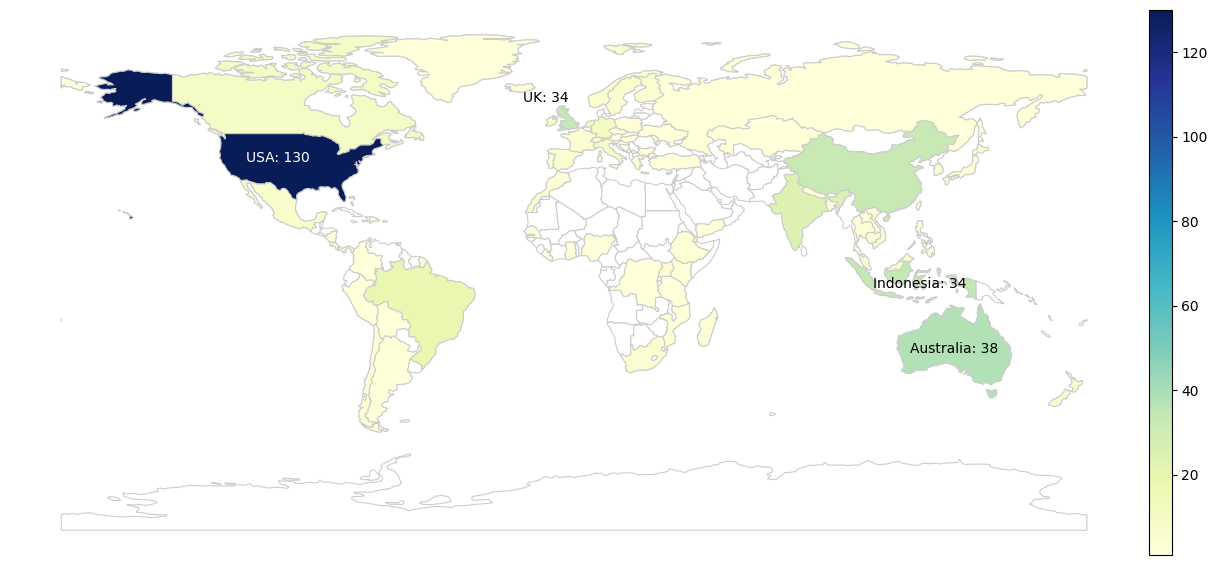

In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
data = pd.read_csv('../MT data/counts_NER.csv')

# Merge the counts with the world map
merged = world.merge(data, left_on='name', right_on='name')

usa_count = merged.loc[merged.name=="United States of America", "count"].values[0]
uk_count = merged.loc[merged.name=="United Kingdom", "count"].values[0]
indonesia_count = merged.loc[merged.name=="Indonesia", "count"].values[0]
aus_count = merged.loc[merged.name=="Australia", "count"].values[0]
print_usa = f"USA: {usa_count}"
print_uk = f"UK: {uk_count}"
print_indonesia = f"Indonesia: {indonesia_count}"
print_aus = f"Australia: {aus_count}"

# Plot the choropleth map
fig, ax = plt.subplots(figsize=(15, 8))

from mpl_toolkits.axes_grid1 import make_axes_locatable


divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="2%", pad=0.1)

ax = merged.plot(column='count', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax = cax)

ax.text(-115, 39, print_usa, c="white", zorder=15)
ax.text(105, -5, print_indonesia, c="black", zorder=15)
ax.text(-18, 60, print_uk, c="black", zorder=15)
ax.text(118, -28, print_aus, c="black", zorder=15)
world.plot(column = 'name', color= "white", linewidth=0.8, edgecolor='0.8', zorder=0, ax=ax)


# Set the axis and title
ax.axis('off')
plt.savefig('../MT data/Geographical_map.png')

In [10]:
#Show the entrances per country
India_count = data.loc[data['name'] == 'India', 'count'].values[0]
print(India_count)
Indonesia_count = data.loc[data['name'] == 'Indonesia', 'count'].values[0]
print(Indonesia_count)
Brazil_count = data.loc[data['name'] == 'Brazil', 'count'].values[0]
print(Brazil_count)
SA_count = data.loc[data['name'] == 'South Africa', 'count'].values[0]
print(SA_count)
GER_count = data.loc[data['name'] == 'Germany', 'count'].values[0]
print(GER_count)

24
34
19
5
11


In [13]:
#Show the number of countries with one entrance
num_entries = len(data.loc[data['count'] == 1])
print(num_entries)

countries = data.loc[data['count'] == 1, 'name'].tolist()

24


In [41]:
data_con = pd.read_excel('../MT data/long_lat_new.xlsx')

# Drop rows with missing values in Latitude_Country and Longitude_Country columns
data_con = data_con.dropna(subset=['Latitude_Country', 'Longitude_Country', 'Country'])

# load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
data_con = gpd.GeoDataFrame(data_con, geometry=gpd.points_from_xy(data_con.Longitude_Country, data_con.Latitude_Country))
data.crs = 'epsg:4326'
data_con = gpd.sjoin(data_con, world, how="left", op='intersects')
data_con.to_csv('../MT data/continent_NER.csv', index=False)


/Users/annamohn/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/hx/r9c1jp511v15x5_0hmwf10p80000gn/T/ipykernel_75810/1409420699.py:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  data_con = gpd.sjoin(data_con, world, how="left", op='intersects')


In [16]:
#manually checked the data and identified changes necessary to Indonesia and Philippines as there is no continent attributed
continent = pd.read_csv('../MT data/continent_NER.csv')
continent.loc[continent['Country'].isin(['Indonesia', 'Philippines']), 'continent'] = 'Asia'
continent.loc[continent['Country'] == 'Denmark', 'continent'] = 'Europe'

<AxesSubplot: xlabel='continent'>

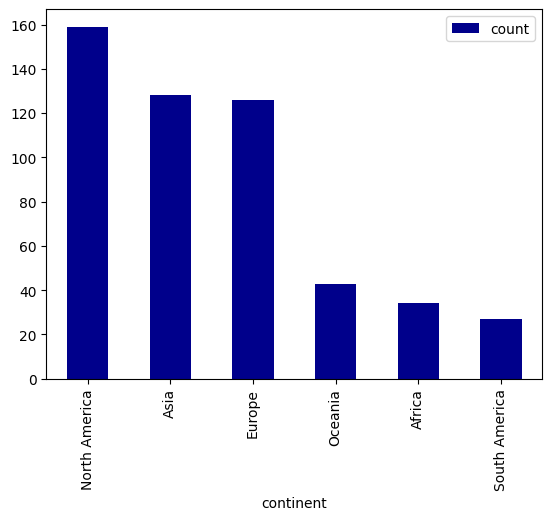

In [17]:
#Create a bar chart
continent_counts = continent['continent'].value_counts().reset_index()
continent_counts.columns = ['continent', 'count']
continent_counts.plot.bar(x='continent', y='count', color='darkblue')

In [18]:
#Show the numbers
continent_counts

,continent,count
0,North America,159
1,Asia,128
2,Europe,126
3,Oceania,43
4,Africa,34
5,South America,27


Distribution for CDR technologies

In [45]:
data_tech = continent[['id', 'continent']]
year = pd.read_csv('../MT data/year.csv')

In [46]:
data_tech = data_tech.merge(year, on="id", how="left")

/var/folders/hx/r9c1jp511v15x5_0hmwf10p80000gn/T/ipykernel_75810/813765336.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  technology = data_tech.groupby('continent').sum()
/var/folders/hx/r9c1jp511v15x5_0hmwf10p80000gn/T/ipykernel_75810/813765336.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  technology = data_tech.groupby('continent').sum()


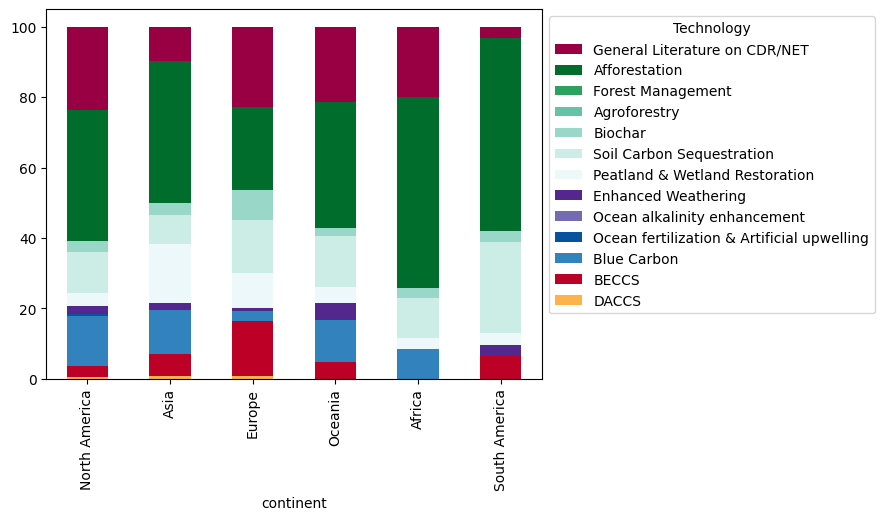

,DACCS,BECCS,Blue Carbon,Ocean fertilization & Artificial upwelling,Ocean alkalinity enhancement,Enhanced Weathering,Peatland & Wetland Restoration,Soil Carbon Sequestration,Biochar,Agroforestry,Forest Management,Afforestation,General Literature on CDR/NET
continent,,,,,,,,,,,,,
North America,0.609756,3.048780,14.024390,0.609756,0.0,2.439024,3.658537,11.585366,3.048780,0.0,0.0,37.195122,23.780488
Asia,0.694444,6.250000,12.500000,0.000000,0.0,2.083333,16.666667,8.333333,3.472222,0.0,0.0,40.277778,9.722222
Europe,0.714286,15.714286,2.857143,0.000000,0.0,0.714286,10.000000,15.000000,8.571429,0.0,0.0,23.571429,22.857143
Oceania,0.000000,4.761905,11.904762,0.000000,0.0,4.761905,4.761905,14.285714,2.380952,0.0,0.0,35.714286,21.428571
Africa,0.000000,0.000000,8.571429,0.000000,0.0,0.000000,2.857143,11.428571,2.857143,0.0,0.0,54.285714,20.000000
South America,0.000000,6.451613,0.000000,0.000000,0.0,3.225806,3.225806,25.806452,3.225806,0.0,0.0,54.838710,3.225806


In [74]:
#Change the order of the column contient
continent_order = ['North America', 'Asia', 'Europe', 'Oceania', 'Africa','South America' ]
data_tech['continent'] = pd.Categorical(data_tech['continent'], categories=continent_order)

#Group the data by continent and sum the values
technology = data_tech.groupby('continent').sum()
technology = technology.rename(columns={'AR': 'Afforestation', 
                                        'restoration of landscapes/peats': 'Peatland & Wetland Restoration', 
                                        "Enhanced Weathering (land based)": "Enhanced Weathering",
                                        "DAC(CS)": "DACCS"})
all_technologies = ["General Literature on CDR/NET", 
                    "Afforestation", 
                    "Forest Management",
                    "Agroforestry",
                    "Biochar",
                    "Soil Carbon Sequestration",
                    "Peatland & Wetland Restoration",
                    "Enhanced Weathering",
                    "Ocean alkalinity enhancement",
                    "Ocean fertilization & Artificial upwelling",
                    "Blue Carbon",
                    "BECCS",
                    "DACCS"]
#Make the plot
colors_tech = ['#980043', '#006d2c', '#2ca25f', '#66c2a4', '#99d8c9', '#ccece6', '#edf8fb', '#54278f', '#756bb1', '#08519c', '#3182bd', '#bd0026', '#feb24c']
technology = technology[all_technologies[::-1]]
percentages_tech = technology.div(technology.sum(axis=1), axis=0).multiply(100)
percentages_tech.plot.bar(stacked=True, color = colors_tech[::-1])

handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]

plt.legend(title="Technology", loc="upper left", bbox_to_anchor=(1,1), handles=handles, labels=labels)

plt.show()

Distribution for policy instruments

/var/folders/hx/r9c1jp511v15x5_0hmwf10p80000gn/T/ipykernel_75810/3099496318.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  policy = data_tech.groupby('continent').sum()


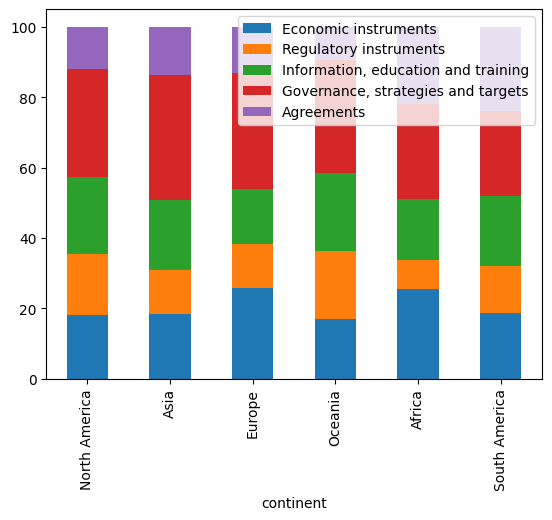

,Economic instruments,Regulatory instruments,"Information, education and training","Governance, strategies and targets",Agreements
continent,,,,,
North America,17.987805,17.378049,21.951220,30.792683,11.890244
Asia,18.478261,12.318841,19.927536,35.507246,13.768116
Europe,25.877193,12.280702,15.789474,32.894737,13.157895
Oceania,17.021277,19.148936,22.340426,31.914894,9.574468
Africa,25.581395,8.139535,17.441860,26.744186,22.093023
South America,18.666667,13.333333,20.000000,24.000000,24.000000


In [73]:
data_tech['continent'] = pd.Categorical(data_tech['continent'], categories=continent_order)
policy = data_tech.groupby('continent').sum()

all_policies = ["Economic instruments", 
                "Regulatory instruments",
                "Information, education and training",
                "Governance, strategies and targets",
                "Agreements"]
colors_pol = ['#66c2a5','#fc8d62', '#8da0cb', '#e78ac3', '#a6d854' ]


policy = policy[all_policies]
percentages_pol = policy.div(policy.sum(axis=1), axis=0).multiply(100)
percentages_pol.plot.bar(stacked=True)
plt.show()

Merge everything

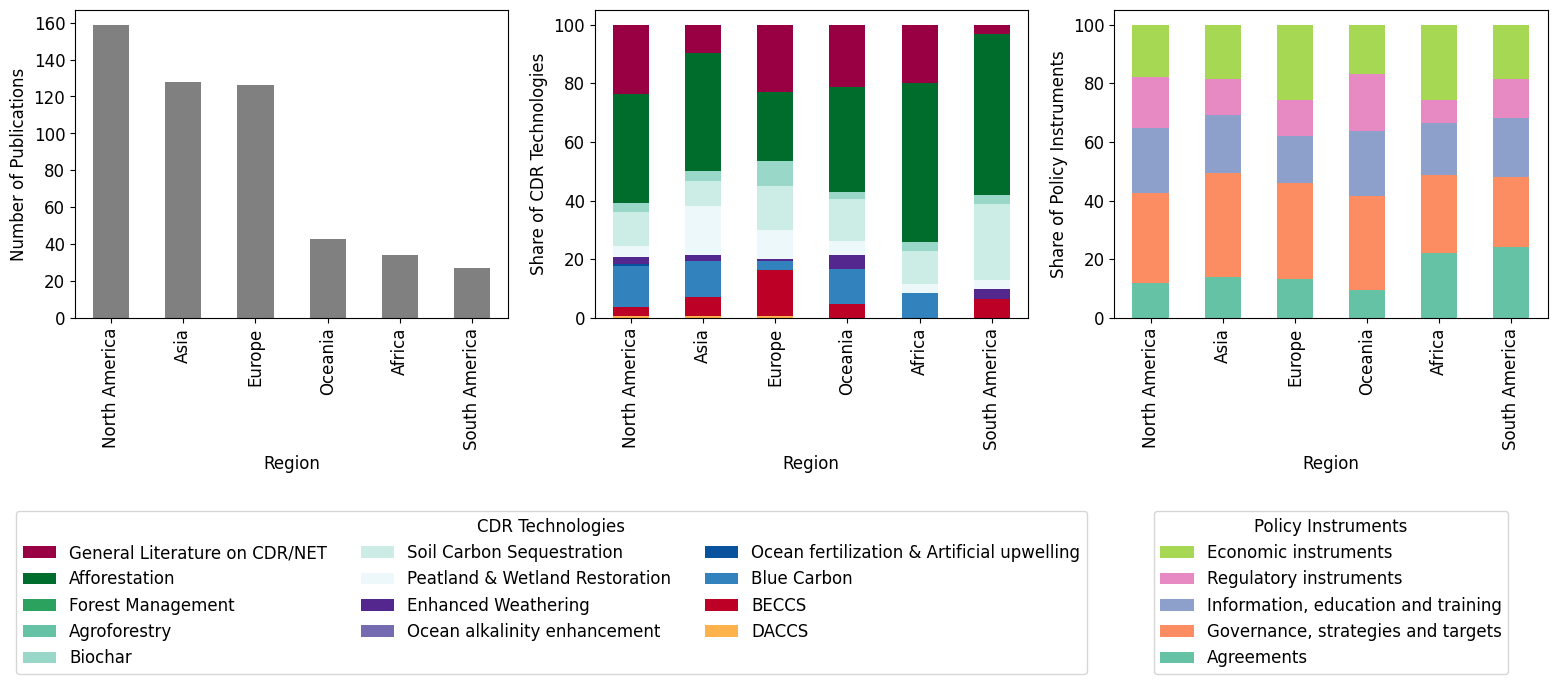

In [63]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(1, 3, figsize=(19,4))

continent_counts.plot(kind='bar', x='continent', color='grey', ax=ax[0], legend=False, fontsize = 12)
ax[0].set_ylabel("Number of Publications", fontsize = 12)
ax[0].set_xlabel("Region", fontsize = 12)

ax1 = percentages_tech.plot(kind='bar', stacked=True, color=colors_tech[::-1], ax=ax[1], fontsize = 12)
ax[1].set_ylabel("Share of CDR Technologies", fontsize = 12)
ax[1].set_xlabel("Region", fontsize = 12)

handles, labels = ax[1].get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]
ax[1].legend(handles, labels, title="CDR Technologies", loc="upper center", ncol = 3, bbox_to_anchor=(-0.1, -0.6), fontsize = 12, title_fontsize=12)

percentages_pol = percentages_pol.iloc[:, ::-1]
percentages_pol.plot(kind='bar', stacked = True, color = colors_pol, ax=ax[2], fontsize = 12)
ax[2].set_ylabel("Share of Policy Instruments", fontsize = 12)
ax[2].set_xlabel("Region", fontsize = 12)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(reversed(handles), reversed(labels), title = "Policy Instruments", bbox_to_anchor=(0.5, -0.6), loc='upper center', ncol=1, fontsize = 12, title_fontsize=12)

plt.show()

fig.subplots_adjust(bottom=0.2, top=0.9)

fig.savefig('../MT data/Papers by Region.png', dpi=300, bbox_inches='tight')
